In [1]:
import torch

In [2]:
import time

In [3]:
torch.cuda.memory_allocated()

0

In [4]:
from datetime import datetime
import pytz

In [5]:
IST = pytz.timezone('Asia/Kolkata')

In [6]:
datetime_ist = datetime.now(IST)


In [7]:
print("Date & Time in IST : ", 
      datetime_ist.strftime('%Y:%m:%d %H:%M:%S %Z %z'))

Date & Time in IST :  2021:07:03 16:14:16 IST +0530


In [8]:
import matplotlib.pyplot as plt

In [9]:
import torchvision

In [10]:
import os

# Importing CIFAR dataset

In [11]:
from torchvision.datasets import CIFAR10

In [12]:
from torchvision.datasets.utils import download_url

In [13]:
from torchvision.transforms import ToTensor

In [14]:
import tarfile

In [15]:
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url, '.')

Using downloaded and verified file: .\cifar10.tgz


In [16]:
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')

In [17]:
os.listdir(os.getcwd()+"/data/cifar10/train")

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [18]:
classes = os.listdir(os.getcwd()+"/data/cifar10/train")

In [19]:
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

# Now lets check how many images are there for each class

In [20]:
for item in classes:
    print(item + " = " + str(len(os.listdir(os.getcwd()+"/data/cifar10/train/"+item))))

airplane = 5000
automobile = 5000
bird = 5000
cat = 5000
deer = 5000
dog = 5000
frog = 5000
horse = 5000
ship = 5000
truck = 5000


In [21]:
data_dir = os.getcwd()+"/data/cifar10/train"

In [22]:
from torchvision.datasets import ImageFolder

In [23]:
from torchvision.transforms import ToTensor

In [24]:
dataset = ImageFolder(data_dir,transform = ToTensor())

In [25]:
dataset

Dataset ImageFolder
    Number of datapoints: 50000
    Root location: F:\Deep Learning\CIFAR/data/cifar10/train
    StandardTransform
Transform: ToTensor()

# Now the dataset has all the training data stored

Label=0
Class= airplane


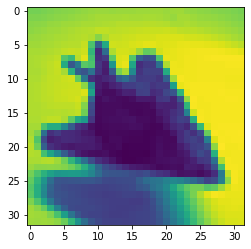

In [26]:
image,label = dataset[0]
print("Label=" + str(label))
print("Class= " + classes[label])
plt.imshow(image[0])

# Now lets split into training set and validation set

In [27]:
from torch.utils.data import random_split

In [28]:
train_set,val_set = random_split(dataset,[45000,5000])

In [29]:
len(train_set)

45000

In [30]:
len(val_set)

5000

In [31]:
from torch.utils.data import DataLoader

### `Pin memory is made True to enable the tensor to be stored in gpu

In [32]:
train_dl = DataLoader(train_set,batch_size= 128,shuffle=True,pin_memory= True)
val_dl = DataLoader(val_set,batch_size= 128*2,shuffle=False,pin_memory= True)

In [33]:
for images,labels in train_dl:
    print("Image Shape = " + str(images.shape))
    print("Number of labels=" + str(len(labels)))
    break
    

Image Shape = torch.Size([128, 3, 32, 32])
Number of labels=128


In [34]:
from torchvision.utils import make_grid

In [35]:
plt.figure(figsize=(30,6))

<Figure size 2160x432 with 0 Axes>

<Figure size 2160x432 with 0 Axes>

torch.Size([3, 274, 546])
torch.Size([274, 546, 3])


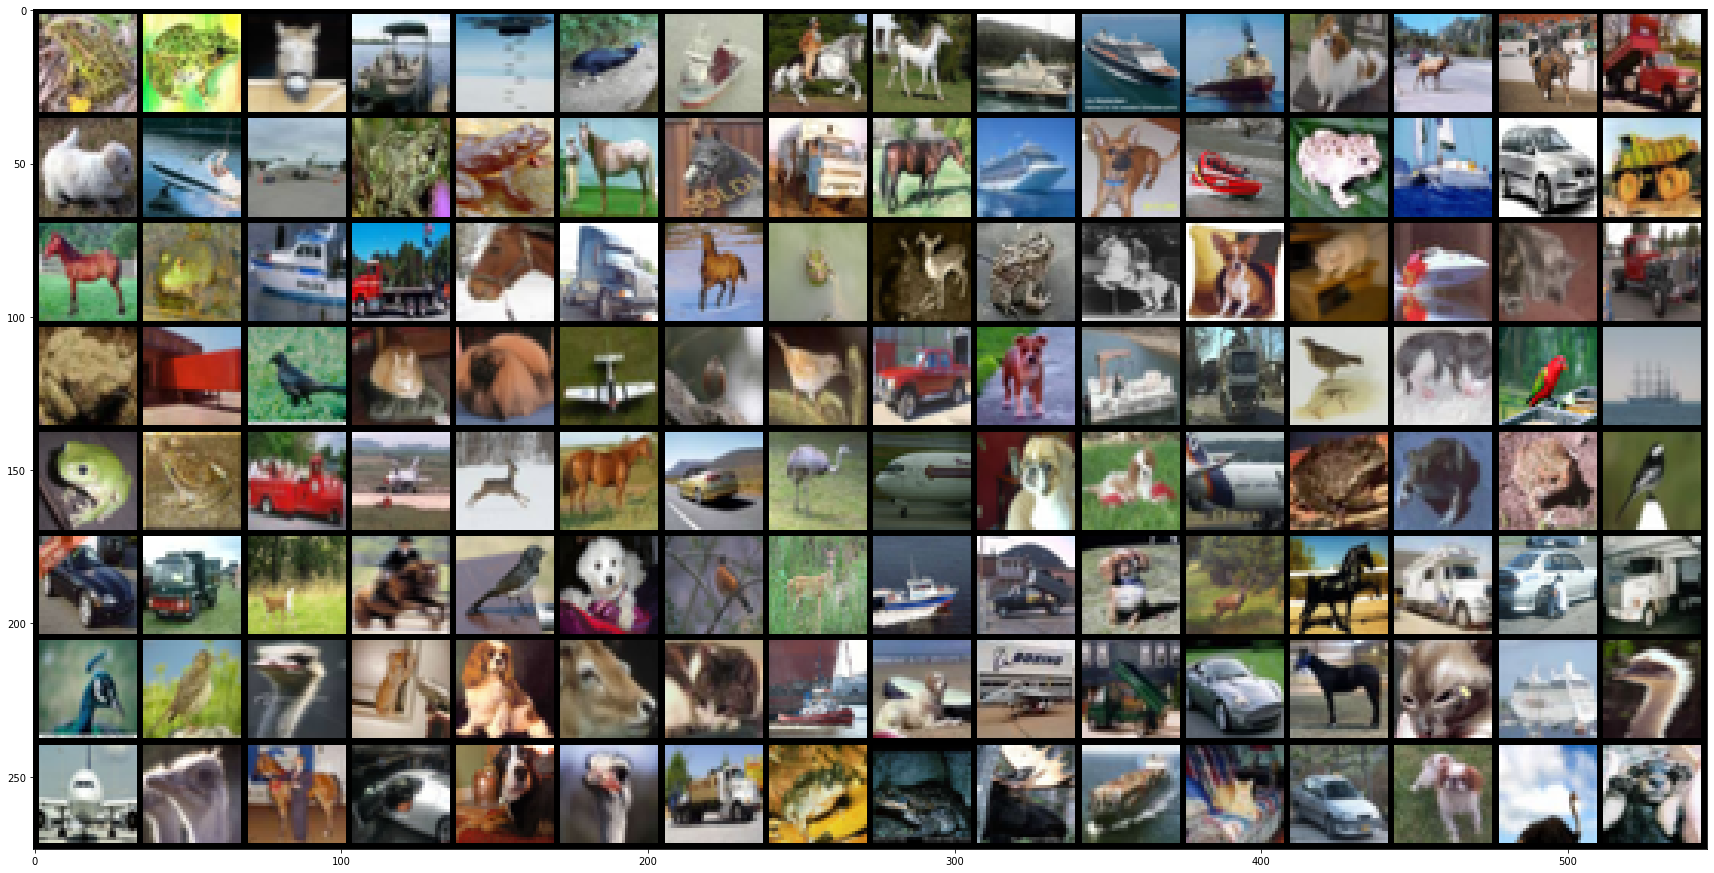

In [36]:
for images,labels in train_dl:
    plt.figure(figsize=(30,20))
    print(make_grid(images, nrow=16).shape)
    print(make_grid(images, nrow=16).permute(1, 2, 0).shape)
    plt.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
    break

# The following code is used to train the model using gpu

In [37]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [38]:
device = get_default_device()
device

device(type='cuda')

# Lets test out a sample sequential model

In [39]:
import torch.nn as nn

In [40]:
sample_model = nn.Sequential(
nn.Conv2d(3,8,kernel_size=3,padding='same'),
nn.ReLU()
)

In [41]:
sample_model

Sequential(
  (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (1): ReLU()
)

In [42]:
for images,labels in train_dl:
    out = sample_model(images)
    print(images.shape)
    print(out.shape)
    print(torch.min(out))
    break

torch.Size([128, 3, 32, 32])
torch.Size([128, 8, 32, 32])
tensor(0., grad_fn=<MinBackward1>)


# Creating our imageClassification base class

In [43]:
import torch.nn.functional as F

In [44]:
def accuracy(out,labels):
    _,preds = torch.max(out,dim=1)
    acc = torch.tensor(torch.sum(preds == labels).item() / len(preds))
    return acc

In [45]:
class ImageClassificationBase(nn.Module):
    
    def training_step(self,batch):
        images,labels = batch
        output = self(images)
        loss = F.cross_entropy(output,labels)
        return loss
    
    def validation_step(self,batch):
        images,labels = batch
        output = self(images)
#         print("out size=",output.shape)
        loss = F.cross_entropy(output,labels)
        
        acc = accuracy(output,labels)
        
        return {"val_loss":loss,"accuracy":acc}
    
    def validation_epoch_end(self,outputs):
        batch_loss = [output["val_loss"] for output in outputs]
        batch_accuracy = [output["accuracy"] for output in outputs]
        epoch_loss = torch.stack(batch_loss).mean()
        epoch_acc = torch.stack(batch_accuracy).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
    

In [46]:
class Cifar10CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))
        
    def forward(self,images):
        return self.network(images)

In [47]:
model = Cifar10CnnModel()

In [48]:
model

Cifar10CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_feat

# Input of size  [128, 3, 32, 32] is converted to output of size [128, 10] by the model

In [49]:
for images,labels in train_dl:
    out = model(images)
    print(images.shape)
    print(out.shape)
    print(torch.min(out))
    print(out[0])
    break

C:\Users\91936\Anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


torch.Size([128, 3, 32, 32])
torch.Size([128, 10])
tensor(-0.0308, grad_fn=<MinBackward1>)
tensor([-0.0305, -0.0031,  0.0267,  0.0236, -0.0112,  0.0349,  0.0139,  0.0161,
        -0.0030, -0.0275], grad_fn=<SelectBackward>)


# Lets move our data into gpu

In [50]:
device = get_default_device()
device


device(type='cuda')

In [51]:
torch.cuda.memory_allocated()

0

In [52]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

# Lets train the model

In [53]:
@torch.no_grad()
def evaluate(model,val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    optimizer = opt_func(model.parameters(),lr)
    history = []
    for epoch in range(epochs):
        print("epoch starts")
        model.train()
        train_losses = []
        for  batch in train_loader:
           
            loss = model.training_step(batch)
            
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        print("evaluation starts")
        result = evaluate(model,val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history
        

In [54]:
model = to_device(Cifar10CnnModel(), device)

In [55]:
torch.cuda.memory_allocated()

47468544

In [56]:
torch.cuda.empty_cache()

In [57]:
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |   46356 KB |   46356 KB |   46356 KB |       0 B  |
|       from large pool |   44416 KB |   44416 KB |   44416 KB |       0 B  |
|       from small pool |    1940 KB |    1940 KB |    1940 KB |       0 B  |
|---------------------------------------------------------------------------|
| Active memory         |   46356 KB |   46356 KB |   46356 KB |       0 B  |
|       from large pool |   44416 KB |   44416 KB |   44416 KB |

# Lets check our initial accuracy with random initialized params


In [58]:
evaluate(model,val_dl)

{'val_loss': 2.30302095413208, 'val_acc': 0.09959788620471954}

In [59]:
torch.cuda.memory_allocated()

47468544

# Now lets train the model with the following hyperparams


In [60]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

In [61]:
print("Date & Time in IST : ", 
      datetime_ist.strftime('%Y:%m:%d %H:%M:%S %Z %z'))

Date & Time in IST :  2021:07:03 16:14:16 IST +0530


In [62]:
a = datetime.now()


In [63]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

epoch starts
evaluation starts
Epoch [0], train_loss: 2.0079, val_loss: 1.6159, val_acc: 0.3927
epoch starts
evaluation starts
Epoch [1], train_loss: 1.4522, val_loss: 1.3380, val_acc: 0.5178
epoch starts
evaluation starts
Epoch [2], train_loss: 1.1781, val_loss: 1.0619, val_acc: 0.6225
epoch starts
evaluation starts
Epoch [3], train_loss: 0.9755, val_loss: 0.9613, val_acc: 0.6549
epoch starts
evaluation starts
Epoch [4], train_loss: 0.8536, val_loss: 0.8791, val_acc: 0.6901
epoch starts
evaluation starts
Epoch [5], train_loss: 0.7481, val_loss: 0.8208, val_acc: 0.7165
epoch starts
evaluation starts
Epoch [6], train_loss: 0.6490, val_loss: 0.8166, val_acc: 0.7159
epoch starts
evaluation starts
Epoch [7], train_loss: 0.5657, val_loss: 0.7787, val_acc: 0.7357
epoch starts
evaluation starts
Epoch [8], train_loss: 0.4757, val_loss: 0.8448, val_acc: 0.7269
epoch starts
evaluation starts
Epoch [9], train_loss: 0.4136, val_loss: 0.8219, val_acc: 0.7367


In [64]:
print("Date & Time in IST : ", 
      datetime_ist.strftime('%Y:%m:%d %H:%M:%S %Z %z'))

Date & Time in IST :  2021:07:03 16:14:16 IST +0530


In [65]:
b = datetime.now()

In [87]:
torch.cuda.memory_allocated()

74653184

In [66]:
print("Time taken to train=",b-a)

Time taken to train= 0:05:16.913336


In [67]:
type(history)

list

In [68]:
[len(history)]

[10]

In [69]:
epochs = [i for i in range(len(history))]


In [70]:
train_loss = [i["train_loss"] for i in history]


In [71]:
val_loss = [i["val_loss"] for i in history]

In [72]:
val_acc = [i["val_acc"] for i in history]

# We have achieved an accuracy of 75%

Text(0, 0.5, 'Accuracy')

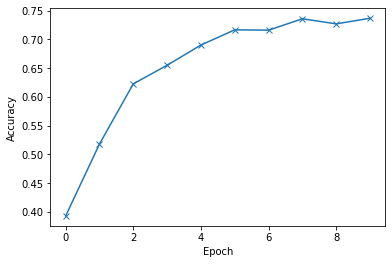

In [73]:
plt.plot(val_acc,'-x')
# plt.plot(epochs,val_loss)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

# We can see overfitting after the 4th epoch.So its best to apply early stopping for our model to work best with real world data

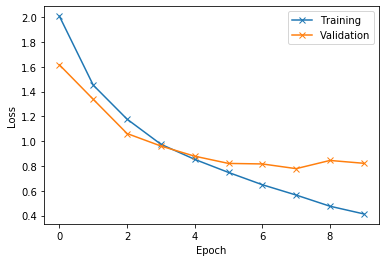

In [74]:
plt.plot(train_loss,'-x')
plt.plot(val_loss,'-x')
# plt.plot(epochs,val_loss)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(['Training', 'Validation'])

# Now lets test our model using test data

In [75]:
test_data_dir  = os.getcwd()+"/data/cifar10/test"

In [76]:
test_dataset = ImageFolder(test_data_dir,transform = ToTensor())

In [77]:
test_dataset

Dataset ImageFolder
    Number of datapoints: 10000
    Root location: F:\Deep Learning\CIFAR/data/cifar10/test
    StandardTransform
Transform: ToTensor()

In [78]:
test_image,test_label = test_dataset[0]

In [79]:
test_image.shape

torch.Size([3, 32, 32])

In [80]:
test_image.unsqueeze(0).shape

torch.Size([1, 3, 32, 32])

In [81]:
xb = to_device(test_image.unsqueeze(0), device)

In [82]:
yb = model(xb)

In [83]:
yb

tensor([[ 4.1610, -3.2218,  0.0619, -3.0528,  0.9518, -4.9117, -6.8889, -2.8121,
         -1.6288, -2.4995]], device='cuda:0', grad_fn=<AddmmBackward>)

In [84]:
_,preds = torch.max(yb,dim=1)

In [85]:
preds.item()

0

In [86]:
label

0

# We get an accuracy of 73% for the test dataset!Not bad right!

In [89]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, 128*2), device)
result = evaluate(model, test_loader)
result

{'val_loss': 0.8135132193565369, 'val_acc': 0.73388671875}